# Transfer Learning approach with the Tensorflow EfficientNet model

## Import des librairies

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import pathlib
import itertools
import random
import time
import setuptools
import datetime

from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

print("tensorflow version",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-09-30 11:38:22.779561: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 11:38:22.783091: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 11:38:22.794062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 11:38:22.813315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 11:38:22.819202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 11:38:22.834455: I tensorflow/core/platform/cpu_feature_gu

tensorflow version 2.17.0
Num GPUs Available:  0


## Récupération des datas

In [2]:
mo_db_path="../../data/LAYER2/MO/train/"
names_csv_path="../../data/LAYER2/names.csv"
data_dir = pathlib.Path(mo_db_path)

def get_champi_name(mo_db_path, names_csv_path):
    """
    Retourne le nom de la classe du champignon depuis le fichier names.csv de Mushroom Observer.
    Requiere numpy, pandas et os.

    Args:
        mo_db_path : Chemin vers le dossier contenant les classes
        names_csv_path : Chemin vers le fichier names.csv

    Returns:
        Dataframe Pandas avec IDs et noms
    """
    # Imports des sources
    data_files = os.listdir(mo_db_path)
    names = pd.read_csv(names_csv_path, delimiter='\t', index_col=0)

    # Recupération des ID des classes
    champi_classes = []
    for item in data_files:
        champi_classes.append(int(item))
    
    # Creation du DataFrame
    df = names[["text_name"]].rename(columns={'text_name': 'name'})
    df = df.loc[champi_classes]

    # Resultat
    return df
    
df = get_champi_name(mo_db_path, names_csv_path)

print(len(df), 'classes')
display(df)

16 classes


,name
id,
42,Trametes versicolor
53,Stropharia ambigua
267,Fuligo septica
330,Cantharellus cinnabarinus
344,Boletus edulis
362,Amanita velosa
373,Amanita muscaria
382,Amanita bisporigera
401,Agaricus augustus


## Chargement des datas

### Créer les ensembles de données

Found 112000 files belonging to 16 classes.
Found 48000 files belonging to 16 classes.
Found 1360 files belonging to 16 classes.
Classes sauvegardées :  ['1174', '15162', '1540', '267', '271', '330', '344', '362', '373', '382', '401', '407', '42', '4920', '53', '939']


2024-09-30 11:38:41.368217: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


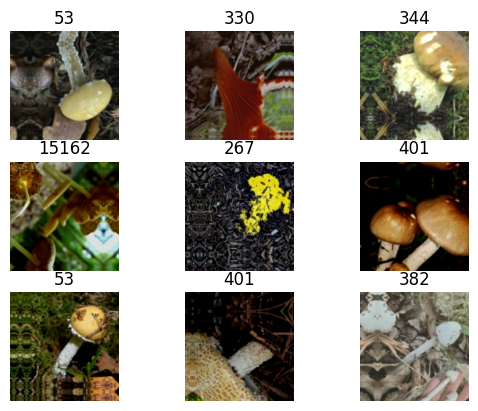

In [3]:
data_dir = '../../data/LAYER2/MO/'
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + '/train',
  validation_split=None,
  subset=None,
  shuffle=True,
  seed=random.randint(1,9999),
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + '/validation',
  validation_split=None,
  subset=None,
  shuffle=True,
  seed=random.randint(1,9999),
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + '/test',
  validation_split=None,
  subset=None,
  shuffle=False,
  seed=random.randint(1,9999),
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# Sauvegarder les classes
class_names = train_ds.class_names
np.save('class_names.npy', class_names)
print("Classes sauvegardées : ", class_names)

# Visualiser un échantillon
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Création du CNN

In [4]:
# Charger le modèle pré-entraîné sur ImageNet
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congeler les couches de base
for layer in base_model.layers:
    layer.trainable = False

# Couches de sorie
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 7,306,071 (27.87 MB)

 Trainable params: 730,832 (2.79 MB)

 Non-trainable params: 6,575,239 (25.08 MB)

## Entrainement

In [5]:
# Configuration pour les performances afin d'éviter une saturation de la RAM
options = tf.data.Options()

# Stop magic stuff that eats up RAM:
options.autotune.enabled = False
options.experimental_distribute.auto_shard_policy = (
  tf.data.experimental.AutoShardPolicy.OFF)
options.experimental_optimization.inject_prefetch = False

train_ds = train_ds.with_options(options)
val_ds = val_ds.with_options(options)

In [11]:
# Mise en place de Tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [12]:
epochs=9

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=0.001), EarlyStopping(monitor='val_loss', patience=3), tensorboard_callback] # Reduction du LR + EarlyStop + Tensorboard
  )

Epoch 1/9
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 4666s 1s/step - accuracy: 0.7257 - loss: 0.8521 - val_accuracy: 0.8565 - val_loss: 0.5012 - learning_rate: 0.0010
Epoch 2/9
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 4777s 1s/step - accuracy: 0.9306 - loss: 0.2337 - val_accuracy: 0.8615 - val_loss: 0.5271 - learning_rate: 0.0010
Epoch 3/9
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 4799s 1s/step - accuracy: 0.9503 - loss: 0.1681 - val_accuracy: 0.8585 - val_loss: 0.5629 - learning_rate: 0.0010
Epoch 4/9
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 4786s 1s/step - accuracy: 0.9589 - loss: 0.1402 - val_accuracy: 0.8645 - val_loss: 0.5321 - learning_rate: 0.0010


# Évaluation finale

In [15]:
# Charger les noms de classes
class_names = np.load('class_names.npy')

# Effectuer les prédictions
predictions = model.predict(test_ds)

# Trouver les classes prédites
predicted_classes = np.argmax(predictions, axis=1)

# Associer les indices aux noms de classes
predicted_classes_names = [class_names[i] for i in predicted_classes]

# Afficher les résultats
print("Classes prédites :", predicted_classes_names)

43/43 ━━━━━━━━━━━━━━━━━━━━ 44s 978ms/step
Classes prédites : ['1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '271', '4920', '1174', '1174', '271', '1174', '362', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '271', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '15162', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '1174', '271', '1174', '1174', '1174', '42', '1174', 

43/43 ━━━━━━━━━━━━━━━━━━━━ 39s 916ms/step


2024-09-30 19:27:17.615592: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


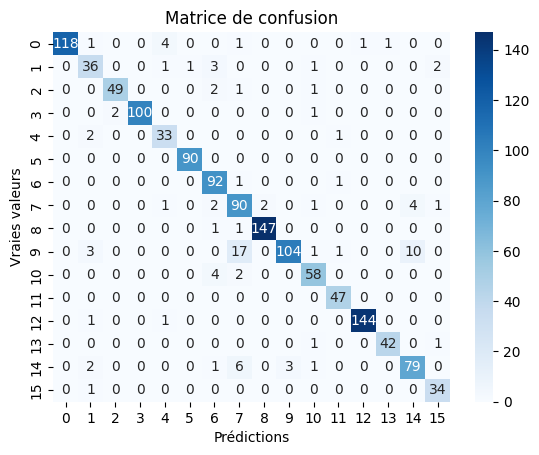

In [16]:
#  Matrice de confusion
y_pred_probs = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

conf_matrix = confusion_matrix(true_labels, y_pred_classes)

sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.show();

# Envoi des informations sur le serveur de tracking

In [31]:
# Imports et paramétrage de MLflow
import mlflow
from mlflow.keras import MlflowCallback
from mlflow import MlflowClient
import setuptools
import requests

# Initialisation de l'URL
mlflow_server_uri = "https://champi.heuzef.com"
mlflow.set_tracking_uri(mlflow_server_uri)

def is_mlflow_tracking_server_available(mlflow_server_uri):
  try:
    response = requests.get(mlflow_server_uri)
    if response.status_code == 200:
      return True
    else:
      return False
  except requests.exceptions.RequestException:
    return False

if is_mlflow_tracking_server_available(mlflow_server_uri):
  print("Le serveur de tracking MLflow est disponible :", mlflow_server_uri)
else:
  print("Le serveur de tracking MLflow n'est pas disponible.")

requests.get(mlflow_server_uri)

Le serveur de tracking MLflow est disponible : https://champi.heuzef.com


<Response [200]>

In [43]:
mlflow.end_run()
epochs = 4
mlflow.set_experiment("champi") # Le nom du projet
run_name = "heuzef_efficientnetb1_010" # Le nom de la run

mlflow.start_run(run_name=run_name)
mlflow.log_param("epochs", epochs)
for epoch in range(epochs):
    mlflow.log_metric("accuracy", acc[epoch], step=epoch)
    mlflow.log_metric("val_accuracy", val_acc[epoch], step=epoch)
    mlflow.log_metric("loss", loss[epoch], step=epoch)
    mlflow.log_metric("val_loss", val_loss[epoch], step=epoch)
mlflow.keras.log_model(model, artifact_path=run_name+"_artifacts")
mlflow.end_run()

2024/09/30 21:50:55 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
/home/heuzef/GIT/jan24_cds_mushrooms/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [34]:
print("acc :", acc)
print("val_acc :", val_acc)
print("loss :", loss)
print("val_loss :", val_loss)
print("epochs_range :", epochs_range)

acc : [0.8457232117652893, 0.9367767572402954, 0.9521250128746033, 0.9607678651809692]
val_acc : [0.856458306312561, 0.8615416884422302, 0.8584583401679993, 0.8645208477973938]
loss : [0.4897499084472656, 0.2151074856519699, 0.1635088473558426, 0.1356484740972519]
val_loss : [0.5011836886405945, 0.5270619988441467, 0.5628567934036255, 0.5321077108383179]
epochs_range : range(0, 9)


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calcul des autres métriques sur le jeu de test
accuracy = accuracy_score(true_labels, y_pred_classes)
precision = precision_score(true_labels, y_pred_classes, average='weighted')
recall = recall_score(true_labels, y_pred_classes, average='weighted')
f1 = f1_score(true_labels, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9286764705882353
Precision: 0.9336224871829758
Recall: 0.9286764705882353
F1-score: 0.9290201971718653


In [30]:
!tensorboard --logdir logs/

2024-09-30 21:42:12.968771: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 21:42:12.971925: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 21:42:12.983989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 21:42:13.003770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 21:42:13.009367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 21:42:13.023139: I tensorflow/core/platform/cpu_feature_gu